In [1]:
# Set up working environment
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
import pandas as pd
import numpy as np
import os
import shutil
import maboss
#import ginsim

## Toy model

We have built a toy model showing the difference between the model outputs when we consider the status of the population or not in a feedback loop from a ligand to a receptor. 
The model can be interpreted as a cell differentiation between two cell types T1 and T2. 

The input node I activates a node A, which drives the differntiation into a T1 cell type. In parallel, the node A activates a ligand L, which in turn triggers a receptor R that drives the T2 cell type. To insure mutual exclusivity between the cell types, T2 is only activated in the absence of A and T1 is inhibited by some components of the cascade leading to the T2 cell type.

To simulate both cases using MaBoSS and thus considering a unique cell (or a population of homogeneous cells), or using UPMaBoSS and taking into account the status of the population (some cells may release L, some may not), we use a single model. We define a parameter `$InnerOn` to distinguish between the two cases: a unique cell or a MetaCell.

In [2]:
# Set up the required files
bnd_file ="ToyModelUP.bnd"
cfg_file = "ToyModelUP.cfg"
upp_file = "ToyModelUP.upp"

The update of the receptor R depends on an external parameter `$innerOn`.

In [3]:
model_maboss = maboss.load(bnd_file,cfg_file)
model_maboss.print_bnd()

Node I {


	rate_up = 0.0;
	rate_down = 0.0;
}
Node A {


	rate_up = I ? 1.0 : 0.0;
	rate_down = 0.0;
}

Node L {


	rate_up = A ? 1.0 : 0.0;
	rate_down = 0.0;
}

Node R {


	rate_up = $innerOn ? L : $outerL;
	rate_down = 0.0;
}

Node T1 {


	rate_up = (A & (!T2)) ? 1.0 :0.0;
	rate_down = 0.0;
}

Node T2 {


	rate_up = (R & (!A)) ? 1.0 : 0.0;
	rate_down = 0.0;
}


The activation of R depends on the ligand L:
- If `$innerOn` is set at 1, R is activated by the state of L inside the cell.
- If `$innerOn` is set at 0, R is activated by the population state of L, through the update function of `$outerL` described in the `upp` file.

In [4]:
ufile = open(upp_file, 'r') 
print(ufile.read())
ufile.close()

$outerL u= 5*p[(L) = (1)];
steps = 15;
MaBoSS = MaBoSS;


Let us consider the two cases. Note that the case "innerOn" (single cell simulation) is equivalent to the simulation using MaBoSS since no variables are updated, i.e. the parameter `$outerL` is not used.

In [5]:
model_maboss = maboss.load(bnd_file,cfg_file)
model_maboss.update_parameters(max_time=1)

# Model of a single cell
model_maboss_innerOn = maboss.copy_and_update_parameters(model_maboss,{"$innerOn":1})
model_upmaboss_innerOn = maboss.UpdatePopulation(model_maboss_innerOn, upp_file)

# Model of a population of cells
model_maboss_innerOff = maboss.copy_and_update_parameters(model_maboss,{"$innerOn":0})
model_upmaboss_innerOff = maboss.UpdatePopulation(model_maboss_innerOff, upp_file)

CPU times: user 49.6 ms, sys: 71.4 ms, total: 121 ms
Wall time: 6.41 s


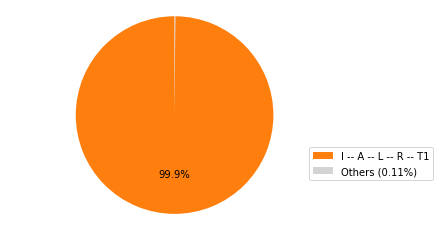

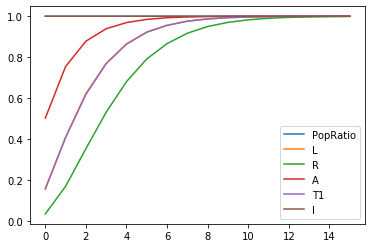

In [6]:
%time ur = model_upmaboss_innerOn.run()

ur.results[-1].plot_piechart()
ur.results[-1]._piefig.savefig("On_pop_pie.pdf")

traj = ur.get_nodes_stepwise_probability_distribution()
p = traj.plot()
p.get_figure().savefig("On_pop_traj.pdf")

CPU times: user 49 ms, sys: 83.2 ms, total: 132 ms
Wall time: 6.39 s


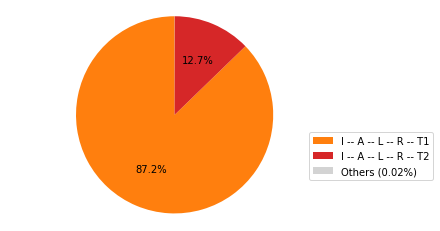

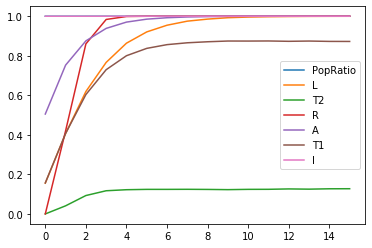

In [7]:
%time ur = model_upmaboss_innerOff.run()

ur.results[-1].plot_piechart()
ur.results[-1]._piefig.savefig("Off_pop_pie.pdf")

traj = ur.get_nodes_stepwise_probability_distribution()
p = traj.plot()
p.get_figure().savefig("Off_pop_traj.pdf")

The node T2 can only be activated if the node R is updated acccording to the population state of L. This is true because in the model where every reaction can take place inside the cell, if R is apresent, then A is present as well and inhibits T2 cell type. In the case of the population model, there will be some cells that will have L active (activated by another cell) and A inactive, allowing the differentiation into T2 cell type. 